### Average Speed ​​Estimation in Traffic by Deep Learning Method Using IBB Traffic Data

#### Loading and importing required libraries

In [ ]:
!pip install pandas
!pip install numpy
!pip install keras
!pip install tensorflow
!pip install matplotlib
!pip install scikit-learn

In [ ]:
!pip install numpy

In [ ]:
!pip install keras

In [ ]:
!pip install tensorflow

In [ ]:
!pip install matplotlib

In [ ]:
!pip install scikit-learn

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

### We are reading train data(2020 12 months data). #Data was taken as csv from the Ibb website.

In [3]:
df = pd.read_csv(r'C:\Users\berrin.gocer\df_new.csv')

In [4]:
df.head()

,_id,DATE_TIME,LATITUDE,LONGITUDE,GEOHASH,MINIMUM_SPEED,MAXIMUM_SPEED,AVERAGE_SPEED,NUMBER_OF_VEHICLES
0,1890.0,2020-01-01T00:00:00,29.207153,40.976257,sxkc0e,113,19,77,40
1,3147.0,2020-01-01T01:00:00,29.207153,40.976257,sxkc0e,119,13,72,43
2,6099.0,2020-01-01T02:00:00,29.207153,40.976257,sxkc0e,131,19,70,33
3,8686.0,2020-01-01T03:00:00,29.207153,40.976257,sxkc0e,123,34,81,16
4,9476.0,2020-01-01T04:00:00,29.207153,40.976257,sxkc0e,114,28,65,13


In [5]:
#kordinatlardan konumun bulunması
from geopy.geocoders import Nominatim

# Koordinatları adreslere dönüştürme
geolocator = Nominatim(user_agent="adres_bulma")
location = geolocator.reverse("40.976257, 29.207153", language='tr')

# Adresi kontrol etme
print(location.address)

Samandıra, Samandıra Caddesi, Eyüp Sultan Mahallesi, Sancaktepe, İstanbul, Marmara Bölgesi, 34885, Türkiye


#### Coordinate Address Used: Samandıra, Samandıra Caddesi, Eyüp Sultan District, Sancaktepe, Istanbul, Marmara Region, 34885, Turkey

In [6]:
#deletion of columns that are not used in the model
df = df.drop(['_id', 'GEOHASH','LATITUDE','LONGITUDE'], axis=1)

In [7]:
df

,DATE_TIME,MINIMUM_SPEED,MAXIMUM_SPEED,AVERAGE_SPEED,NUMBER_OF_VEHICLES
0,2020-01-01T00:00:00,113,19,77,40
1,2020-01-01T01:00:00,119,13,72,43
2,2020-01-01T02:00:00,131,19,70,33
3,2020-01-01T03:00:00,123,34,81,16
4,2020-01-01T04:00:00,114,28,65,13
...,...,...,...,...,...
8637,2020-12-31 19:00:00,112,6,54,140
8638,2020-12-31 20:00:00,124,6,60,95
8639,2020-12-31 21:00:00,114,8,49,42
8640,2020-12-31 22:00:00,114,7,61,23


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8642 entries, 0 to 8641
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   DATE_TIME           8642 non-null   object
 1   MINIMUM_SPEED       8642 non-null   int64 
 2   MAXIMUM_SPEED       8642 non-null   int64 
 3   AVERAGE_SPEED       8642 non-null   int64 
 4   NUMBER_OF_VEHICLES  8642 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 337.7+ KB


## Compression is performed to make time data more meaningful

In [9]:
# We convert the column we received as DATE_TIME object to date format
df['DATE_TIME'] = pd.to_datetime(df['DATE_TIME'])

#Data compression takes place here
df['DATE_TIME'] = df['DATE_TIME'].dt.floor('4H')
df = df.groupby('DATE_TIME').agg({'AVERAGE_SPEED': 'mean', 'MINIMUM_SPEED': 'mean', 'MAXIMUM_SPEED': 'mean', 'NUMBER_OF_VEHICLES': 'mean'}).reset_index()


# Convert 'DATE_TIME' column to timestamp
df['TIMESTAMP'] = df['DATE_TIME'].values.astype(np.int64) // 10**9

In [10]:
df.head()

,DATE_TIME,AVERAGE_SPEED,MINIMUM_SPEED,MAXIMUM_SPEED,NUMBER_OF_VEHICLES,TIMESTAMP
0,2020-01-01 00:00:00,75.00,121.50,21.25,33.00,1577836800
1,2020-01-01 04:00:00,64.25,113.00,19.75,19.50,1577851200
2,2020-01-01 08:00:00,57.00,113.00,8.50,45.25,1577865600
3,2020-01-01 12:00:00,60.50,124.75,6.50,89.25,1577880000
4,2020-01-01 16:00:00,60.00,118.00,7.50,85.00,1577894400


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2170 entries, 0 to 2169
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   DATE_TIME           2170 non-null   datetime64[ns]
 1   AVERAGE_SPEED       2170 non-null   float64       
 2   MINIMUM_SPEED       2170 non-null   float64       
 3   MAXIMUM_SPEED       2170 non-null   float64       
 4   NUMBER_OF_VEHICLES  2170 non-null   float64       
 5   TIMESTAMP           2170 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 101.8 KB


# Model Stage

In [12]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard
import numpy as np

# Select required columns
#X: Represents Feature
#Y: Represents Target
X = df[['TIMESTAMP', 'MINIMUM_SPEED', 'MAXIMUM_SPEED', 'NUMBER_OF_VEHICLES']].values
y = df['AVERAGE_SPEED'].values

# Split the dataset into training and testing
#Test and train data: model learns in train, how much the model learns in test data is tested comparatively
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Normalize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
y_train = scaler.fit_transform(y_train.reshape(-1, 1))
y_test = scaler.transform(y_test.reshape(-1, 1))

# Creating an LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(1, X_train.shape[1])))  # Zaman adımı ekledik
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Define TensorBoard callback
tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1, write_graph=True, write_images=True)

# Train a model and use my TensorBoard callback
history = model.fit(np.expand_dims(X_train, axis=1), y_train, epochs=200, batch_size=64, callbacks=[tensorboard_callback], validation_data=(np.expand_dims(X_test, axis=1), y_test))

Epoch 1/200
28/28 [==============================] - 4s 42ms/step - loss: 0.0613 - val_loss: 0.0187
Epoch 2/200
28/28 [==============================] - 0s 14ms/step - loss: 0.0116 - val_loss: 0.0074
Epoch 3/200
28/28 [==============================] - 0s 15ms/step - loss: 0.0071 - val_loss: 0.0057
Epoch 4/200
28/28 [==============================] - 0s 15ms/step - loss: 0.0068 - val_loss: 0.0054
Epoch 5/200
28/28 [==============================] - 0s 14ms/step - loss: 0.0066 - val_loss: 0.0055
Epoch 6/200
28/28 [==============================] - 0s 14ms/step - loss: 0.0066 - val_loss: 0.0054
Epoch 7/200
28/28 [==============================] - 0s 13ms/step - loss: 0.0065 - val_loss: 0.0055
Epoch 8/200
28/28 [==============================] - 0s 15ms/step - loss: 0.0064 - val_loss: 0.0052
Epoch 9/200
28/28 [==============================] - 0s 14ms/step - loss: 0.0062 - val_loss: 0.0059
Epoch 10/200
28/28 [==============================] - 0s 15ms/step - loss: 0.0062 - val_loss: 0.0088

In [25]:
# Make predictions on test data
y_pred = model.predict(np.expand_dims(X_test, axis=1))

# Reverse normalization of prediction results
y_pred = scaler.inverse_transform(y_pred)

# Comparing actual and predicted values
comparison = pd.DataFrame({'Gerçek': scaler.inverse_transform(y_test.reshape(-1, 1)).flatten(), 'Tahmin': y_pred.flatten()})
print(comparison)

14/14 [==============================] - 0s 5ms/step
       Gerçek    Tahmin
0    3.603550  3.701647
1    3.544379  3.511878
2    3.236686  3.254010
3    3.366864  3.275204
4    3.337278  3.300874
..        ...       ...
429  3.544379  3.504015
430  3.307692  3.216861
431  3.437870  3.297698
432  3.449704  3.230125
433  3.591716  3.629245

[434 rows x 2 columns]


In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               68096     
                                                                 
 dense (Dense)               (None, 256)               33024     
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 167,169
Trainable params: 167,169
Non-trainable params: 0
_________________________________________________________________


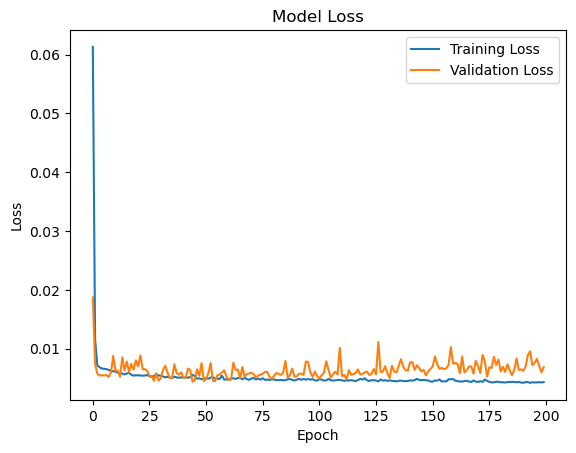

In [27]:
import matplotlib.pyplot as plt

# Comparing actual and predicted values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Graph creation
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')

plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.show()

### Model Performance on Train and Test data # R-Square #MSE #MAE Calculations
### R-Square ranges from 0 to 1 and represents an increase in model performance as it approaches 1.

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

train_preds = model.predict(np.expand_dims(X_train, axis=1))
train_r2 = r2_score(y_train, train_preds)
print("Train R2 Skoru: {:.4f}".format(train_r2))

test_preds = model.predict(np.expand_dims(X_test, axis=1))
test_r2 = r2_score(y_test, test_preds)
print("Test R2 Skoru: {:.4f}".format(test_r2))

55/55 [==============================] - 0s 4ms/step
Train R2 Skoru: 0.7763
14/14 [==============================] - 0s 5ms/step
Test R2 Skoru: 0.6426


### MSE - Mean Squared Error (error rate) The closer to 0, the better the model yield

In [29]:
train_preds = model.predict(np.expand_dims(X_train, axis=1))
train_mse = mean_squared_error(y_train, train_preds)
train_mae = mean_absolute_error(y_train, train_preds)
print("Train MSE: {:.4f}".format(train_mse))

55/55 [==============================] - 0s 3ms/step
Train MSE: 0.0040


### MAE - Mean Absolute Error The closer to 0, the better the model yield

In [30]:
test_preds = model.predict(np.expand_dims(X_test, axis=1))
test_mse = mean_squared_error(y_test, test_preds)
test_mae = mean_absolute_error(y_test, test_preds)
print("Test MAE: {:.4f}".format(test_mae))

14/14 [==============================] - 0s 2ms/step
Test MAE: 0.0684


# Model Outputs: Predicted & Target

In [31]:
# Make predictions on test data
y_pred = model.predict(np.expand_dims(X_test, axis=1))

# Reverse normalization of prediction results
y_pred = scaler.inverse_transform(y_pred)

# Comparing actual and predicted values
comparison = pd.DataFrame({'Gerçek': scaler.inverse_transform(y_test.reshape(-1, 1)).flatten(), 'Tahmin': y_pred.flatten()})
print(comparison)

14/14 [==============================] - 0s 2ms/step
       Gerçek    Tahmin
0    3.603550  3.701647
1    3.544379  3.511878
2    3.236686  3.254010
3    3.366864  3.275204
4    3.337278  3.300874
..        ...       ...
429  3.544379  3.504015
430  3.307692  3.216861
431  3.437870  3.297698
432  3.449704  3.230125
433  3.591716  3.629245

[434 rows x 2 columns]


# Querying the predict value for the desired date to the model

##### First, the desired date is entered manually in the date_string section.
##### Since this data model is trained with timestamp data, it is converted to timestamp format and predict value is obtained.

In [32]:
# Specify the date and time value
date_string = '2020-01-01 10:00:00'

# Convert date and time value to datetime format
date_time = pd.to_datetime(date_string)

# Converting date and time value to timestamp format and printing
timestamp = date_time.timestamp()
print(timestamp)

1577872800.0


In [33]:
df.head()

,DATE_TIME,AVERAGE_SPEED,MINIMUM_SPEED,MAXIMUM_SPEED,NUMBER_OF_VEHICLES,TIMESTAMP
0,2020-01-01 00:00:00,75.00,121.50,21.25,33.00,1577836800
1,2020-01-01 04:00:00,64.25,113.00,19.75,19.50,1577851200
2,2020-01-01 08:00:00,57.00,113.00,8.50,45.25,1577865600
3,2020-01-01 12:00:00,60.50,124.75,6.50,89.25,1577880000
4,2020-01-01 16:00:00,60.00,118.00,7.50,85.00,1577894400


In [34]:
# X: Features: ['TIMESTAMP', 'MINIMUM_SPEED', 'MAXIMUM_SPEED', 'NUMBER_OF_VEHICLES']
# Y: Target:  AVERAGE_SPEED

input_data = np.array([[timestamp, 50, 140, 3]])

# Create MinMaxScaler objects to normalize each feature individually
scalers = []
for _ in range(input_data.shape[1]):
    scaler = MinMaxScaler()
    scalers.append(scaler)

# Normalize each feature separately
input_data_scaled = np.empty_like(input_data)
for i, scaler in enumerate(scalers):
    input_data_scaled[:, i] = scaler.fit_transform(input_data[:, i].reshape(-1, 1)).flatten()

In [35]:
# Reshape and predict input data
input_data_reshaped = np.expand_dims(input_data_scaled, axis=1)
y_pred = model.predict(input_data_reshaped)

# Reverse normalize the prediction result
predicted_average_speed = scalers[-1].inverse_transform(y_pred)

1/1 [==============================] - 0s 23ms/step
